# Training a Reservoir Computer to Predict the Lorenz System

This notebook provides you a complete code example that trains a reservoir computer to predict the evolution of the Lorenz system.


## Numerically Integrating the Lorenz System

Implement a function to propagate the Lorenz system one step ...


In [254]:
def lorenz_step(t, x, y, z, dt, sigma, rho, beta):
    """Calculate the next step in the Lorenz system."""
    dx = sigma * (y - x) * dt
    dy = (x * (rho - z) - y) * dt
    dz = (x * y - beta * z) * dt
    
    return t + dt, x + dx, y + dy, z + dz

... implement a function to obtain a trajectory for the Lorenz system ...


In [255]:
import numpy as np

def lorenz(t0, x0, y0, z0, dt, sigma, rho, beta, iter_num):
    """Calculate the evolution of the Lorenz system."""
    t = np.zeros(iter_num + 1)
    x = np.zeros(iter_num + 1)
    y = np.zeros(iter_num + 1)
    z = np.zeros(iter_num + 1)

    t[0], x[0], y[0], z[0] = t0, x0, y0, z0
    for i in range(iter_num):
        t[i + 1], x[i + 1], y[i + 1], z[i + 1] = (
            lorenz_step(t[i], x[i], y[i], z[i], dt, sigma, rho, beta)
        )
        
    return t, x, y, z

... and integrate the Lorenz system.


In [256]:
t, x, y, z = lorenz(t0=0, x0=1, y0=1, z0=1, dt=0.01,
                    sigma=10, rho=28, beta=8 / 3, iter_num=5_000)

### Visualizing the Time Evolution of the Lorenz System


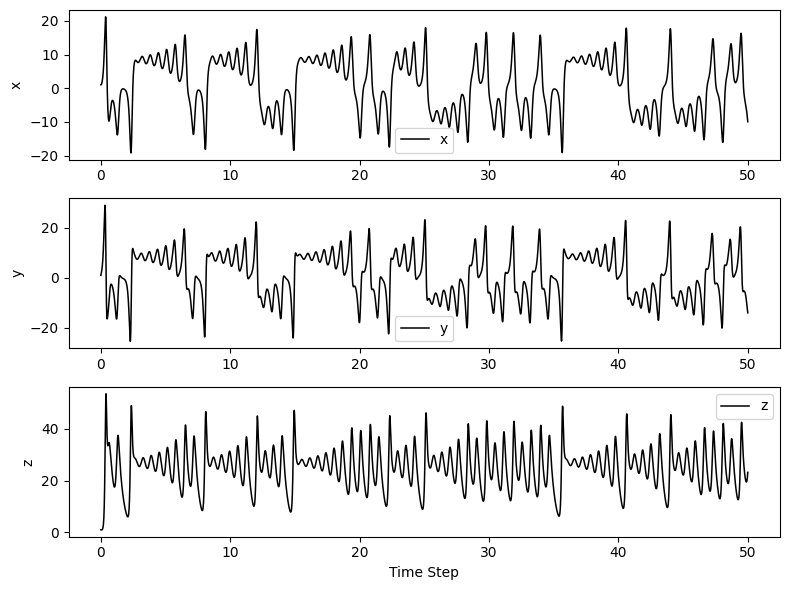

In [257]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(8, 6))  

axs[0].plot(t, x, label="x", color="k", lw=1.1)
axs[0].set_ylabel("x")
axs[0].legend()

axs[1].plot(t, y, label="y", color="k", lw=1.1)
axs[1].set_ylabel("y")
axs[1].legend()

axs[2].plot(t, z, label="z", color="k", lw=1.1)
axs[2].set_ylabel("z")
axs[2].legend()

axs[2].set_xlabel("Time Step")

fig.tight_layout()
plt.show()

### Visualizing the Lorenz Attractor


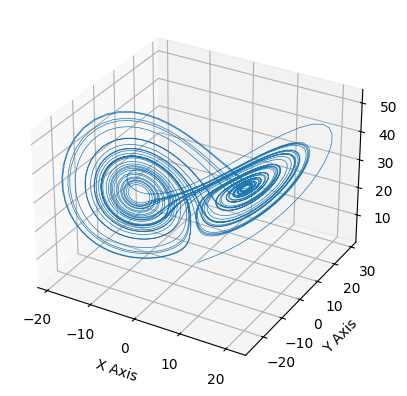

In [258]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot(x, y, z, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
plt.show()

### Demonstrating the Butterfly Effect

Integrate the Lorenz system with a slightly perturbed initial condition ...


In [259]:
t_a, x_a, y_a, z_a = lorenz(t0=0, x0=1 + 0.000_001, y0=1, z0=1, dt=0.01,
                            sigma=10, rho=28, beta=8 / 3, iter_num=5_000)

... plotting the time evolution of the Lorenz system with a slightly perturbed initial
condition ...


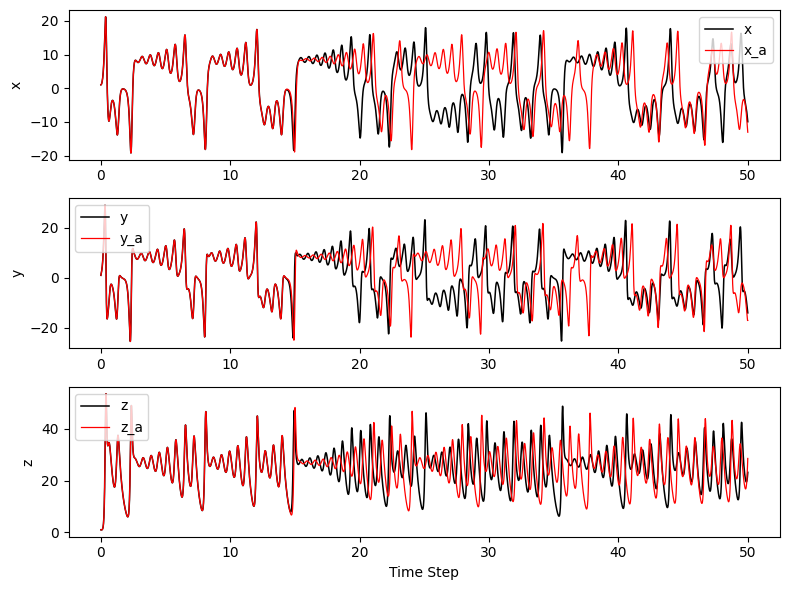

In [260]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(8, 6))  

axs[0].plot(t, x, label="x", color="k", lw=1.1)
axs[0].plot(t_a, x_a, label="x_a", color="red", lw=0.9)
axs[0].set_ylabel("x")
axs[0].legend()

axs[1].plot(t, y, label="y", color="k", lw=1.1)
axs[1].plot(t_a, y_a, label="y_a", color="red", lw=0.9)
axs[1].set_ylabel("y")
axs[1].legend()

axs[2].plot(t, z, label="z", color="k", lw=1.1)
axs[2].plot(t_a, z_a, label="z_a", color="red", lw=0.9)
axs[2].set_ylabel("z")
axs[2].legend()

axs[2].set_xlabel("Time Step")

fig.tight_layout()
plt.show()

... and plot the Lorenz attractor with slightly perturbed initial conditions.


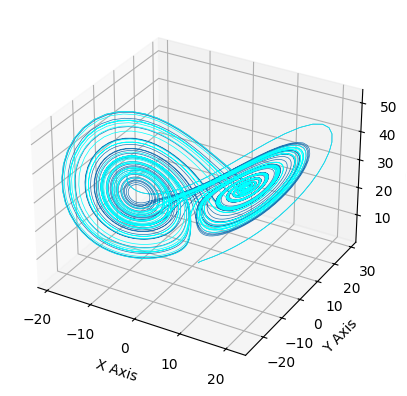

In [261]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot(x, y, z, lw=0.5, label="original")
ax.plot(x_a, y_a, z_a, lw=0.5, color="cyan", label="perturbed")
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
plt.show()

## Implementing a Reservoir Computer


### Setting Up the Reservoir

Define the reservoir input ...


In [262]:
dim_system = 3
dim_reservoir = 300
edge_probability = 0.1

W_in = 2 * edge_probability * (np.random.rand(dim_reservoir, dim_system) - .5)

In [263]:
print(W_in.shape)

(300, 3)


... define the reservoir state ...


In [264]:
reservoir_state = np.zeros(dim_reservoir)

... define the reservoir connections ...


In [265]:
import networkx as nx

scaling_factor = 1.1
graph = nx.gnp_random_graph(dim_reservoir, edge_probability)
graph = nx.to_numpy_array(graph)
A = 2 * (np.random.rand(dim_reservoir, dim_reservoir) - 0.5) * graph
eigenvalues, _ = np.linalg.eig(A)
A = A / np.absolute(np.amax(eigenvalues)) * scaling_factor

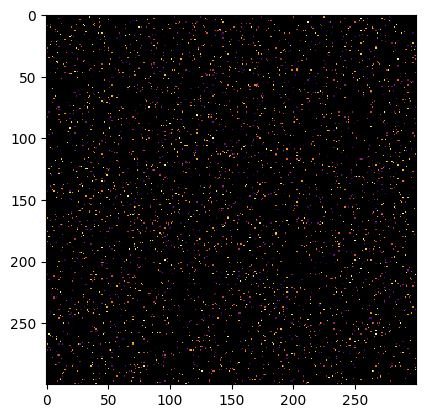

In [266]:
a = np.ma.masked_where(A < 0.05, A)
cmap = plt.get_cmap("inferno")
cmap.set_bad(color='black')

im = plt.imshow(a, interpolation='none', cmap=cmap)


... and initialize the output weights ...


In [267]:
W_out = np.zeros((dim_system, dim_reservoir))

print(W_out.shape)

(3, 300)


To train the weights we dont use backpropagation!


### Preparing the Training and Validation Data


In [268]:
iter_num = 10_000

t, x, y, z = lorenz(t0=0, x0=1, y0=1, z0=1, dt=0.01,
                    sigma=10, rho=28, beta=8 / 3, iter_num=iter_num)
xyz = list(zip(x, y, z))

split_ratio = 0.50
split_idx = int(iter_num * split_ratio)
t_train, xyz_train = t[:split_idx], np.array(xyz[:split_idx])
t_val, xyz_val = t[split_idx:], np.array(xyz[split_idx:])

In [269]:
print(xyz_val.shape)

(5001, 3)


### Training the Reservoir Computer

Implement a numerically stable sigmoid function ...


In [270]:
def sigmoid(x):
    """Compute the sigmoid function for the input array."""
    return np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))

    ## this is a stable version of the sigmoid function

... train the reservoir computer ...


In [271]:
R = np.zeros((dim_reservoir, xyz_train.shape[0]))
for i in range(xyz_train.shape[0]):
    R[:, i] = reservoir_state
    reservoir_state = sigmoid(np.dot(A, reservoir_state)
                              + np.dot(W_in, xyz_train[i]))

Rt = np.transpose(R)
regularization_factor = 0.000001
inverse_part = np.linalg.inv(np.dot(R, Rt)
                             + regularization_factor * np.identity(R.shape[0]))
## the regularization factor is used to help against instability
W_out = np.dot(np.dot(xyz_train.T, Rt), inverse_part)

In [272]:
print(xyz_train.T.shape)
print(Rt.shape)
print(inverse_part.shape)
print(W_out.shape)

(3, 5000)
(5000, 300)
(300, 300)
(3, 300)


... and predict the behavior of the Lorenz system with the trained reservoir computer.


In [273]:
step_to_be_predicted = len(xyz_val)

xyz_pred = np.zeros((step_to_be_predicted, dim_system))
#xyz_pred[0] = xyz_val[0]
for i in range(step_to_be_predicted):
    xyz_pred[i] = np.dot(W_out, reservoir_state)
    reservoir_state = sigmoid(np.dot(A, reservoir_state)
                              + np.dot(W_in, xyz_pred[i]))

## Checking the Performance of the Reservoir Computer

Extract the validation dataset’s individual components and the predicted outcomes from the reservoir computer ...


In [274]:
x_val, y_val, z_val = xyz_val[:, 0], xyz_val[:, 1], xyz_val[:, 2]
x_pred, y_pred, z_pred = xyz_pred[:, 0], xyz_pred[:, 1], xyz_pred[:, 2]

... compare the trajectories ...


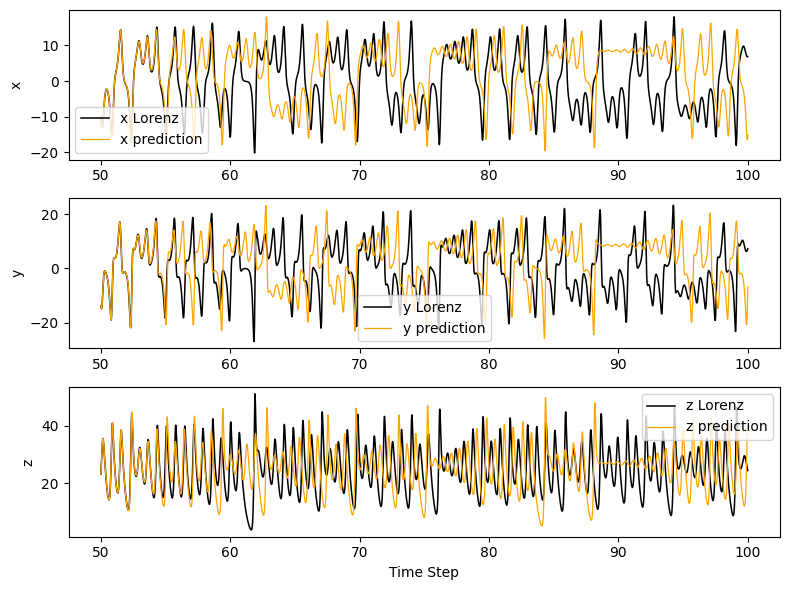

In [275]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6))  

axs[0].plot(t_val, x_val, label="x Lorenz", color="k", lw=1.1)
axs[0].plot(t_val, x_pred, label="x prediction", color="orange", lw=0.9)
axs[0].set_ylabel("x")
axs[0].legend()

axs[1].plot(t_val, y_val, label="y Lorenz", color="k", lw=1.1)
axs[1].plot(t_val, y_pred, label="y prediction", color="orange", lw=0.9)
axs[1].set_ylabel("y")
axs[1].legend()

axs[2].plot(t_val, z_val, label="z Lorenz", color="k", lw=1.1)
axs[2].plot(t_val, z_pred, label="z prediction", color="orange", lw=0.9)
axs[2].set_ylabel("z")
axs[2].legend()

axs[2].set_xlabel("Time Step")

fig.tight_layout()
plt.show()


... compare the Lorenz attractors ...


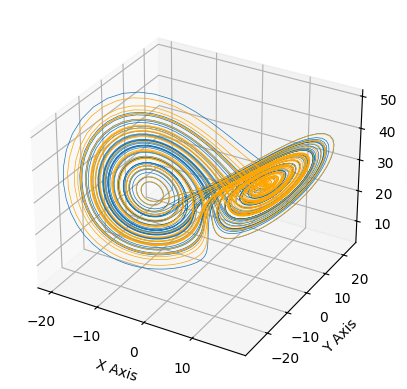

In [276]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

ax.plot(x_val, y_val, z_val, lw=0.5, label="Lorenz system")
ax.plot(x_pred, y_pred, z_pred, lw=0.5, color="orange", label="prediction")

ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")

plt.show()